# Evaluation

In [1]:
from collections import Counter
from copy import copy
from importlib import reload
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import config as cf
import utils as ut

In [2]:
#TODO Label rewriting could be simplified

In [2]:
for mod in cf, ut:
  reload(mod)

In [3]:
# IO
res_main_dir = "/home/ruizfabo/o/ja/23/msca/cpl_ex/06_dsm/ii_xeira_clariah_gal_poster/pp8_mine/pp8_humor_repo/outputs/model_responses/gpt"
md_file = cf.metadata_file
md_df = pd.read_csv(md_file, sep="\t")
ana_dir = cf.error_analysis_dir

# color scheme for confusion matrices based on model name 
clrmap_dict = {"gpt-4o": "Greens", "gpt-35-turbo": "Blues"}

In [4]:
def plot_confusion_matrix(y_preds, y_true, labels, color_key, normalize=None):
  cm = confusion_matrix(y_true, y_preds, normalize=normalize)
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.grid(False)
  font = {'family' : 'Arial',
    'weight' : 'bold',
    'size'   : 16}
  plt.rc('font', **font)
  #labels_for_fig = [l[0:4]+'.' for l in labels]
  labels_for_fig = labels
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels_for_fig)
  #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
  if normalize:
    disp.plot(cmap=clrmap_dict[color_key], values_format=".2f", ax=ax, colorbar=False)
    norm_prefix = "Normalized "
    title_text = "confusion matrix"
  else:
    disp.plot(cmap=clrmap_dict[color_key], ax=ax, colorbar=False)
    norm_prefix = ""
    title_text = ""
  #disp.plot(cmap=clrmap_dict[color_key], values_format=".2f", ax=ax, colorbar=False)
  plt.title(f"{norm_prefix}{title_text}")
  plt.show()


## Binary classification

In [5]:
def eval_res(res_dir, color_mode):
  """
  Evaluate humor judgement results for a directory.

  Return:
      dict
      With keys as follows:
          "sys_orig": original system results before label postprocessing
          "sys_res": system results after preprocessing
          "ref_res": reference results
          "cm": plain text confusion matrix
  """
  assert color_mode in clrmap_dict
  sys_jmt, sys_jmt_no_postpro = ut.get_judgement_info_for_dir(res_dir)
  sys_jmt_orig = copy(sys_jmt)
  sys_jmt = ["other" if kv[1] == 'no' else "comic" for kv in sorted(sys_jmt.items())]
  ref_jmt = ["other" if va == 0 else "comic" for va in md_df['comic'].tolist()]
  labels = ["comic", "other"]
  classif_report = classification_report(ref_jmt, sys_jmt, target_names=labels)
  plot_confusion_matrix(sys_jmt, ref_jmt, labels, color_mode)
  # note: 0, 1 in the plain text cm are class indices,
  # NOT 0 no humor and 1 humor
  plain_cm = confusion_matrix(ref_jmt, sys_jmt, normalize="true")
  return {"sys_orig": sys_jmt_orig, "sys_res_no_postpro": sys_jmt_no_postpro,
          "sys_res": sys_jmt, "ref_res": ref_jmt, "cm": plain_cm, "cr": classif_report}

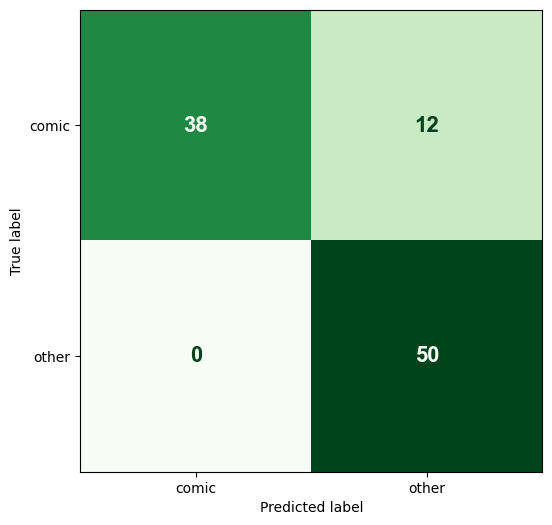

              precision    recall  f1-score   support

       comic       1.00      0.76      0.86        50
       other       0.81      1.00      0.89        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



In [6]:
model_4o = "gpt-4o"
model_4o_res_dir = os.path.join(cf.response_dir, f"gpt/{model_4o}")
res_4o = eval_res(model_4o_res_dir, model_4o)
print(res_4o["cr"])

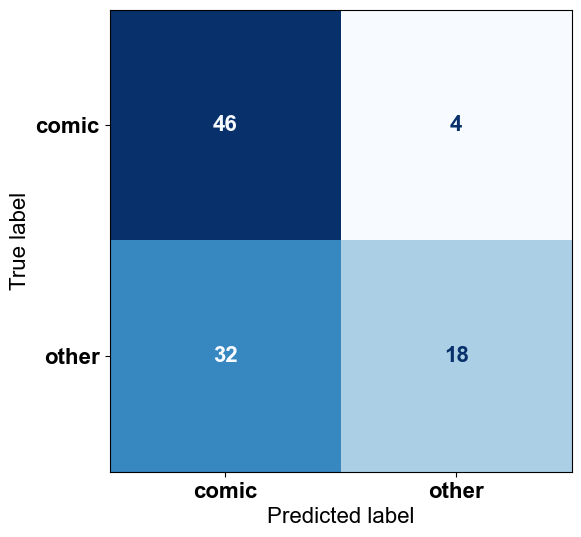

              precision    recall  f1-score   support

       comic       0.59      0.92      0.72        50
       other       0.82      0.36      0.50        50

    accuracy                           0.64       100
   macro avg       0.70      0.64      0.61       100
weighted avg       0.70      0.64      0.61       100



In [7]:
model_35 = "gpt-35-turbo"
model_35_res_dir = os.path.join(cf.response_dir, f"gpt/{model_35}")
res_35 = eval_res(model_35_res_dir, model_35)
print(res_35["cr"])

### Look at gpt-35-turbo errors

In [8]:
def get_error_case_idx_and_metadata(res, md_df):
  """
  Get the indices of the bad results and metadata like author or century.
  Args:
    res (dict): The results to get error cases for; `dict` format produced by `eval_res()`.
    md_df (DataFrame): Dataframe with metadata.

  Returns:
    tuple: Lists with the indices of the bad results, the centuries of the bad results, and the authors of the bad results.
  """
  bad_centuries = []
  bad_authors = []
  bad_idx = []
  print("\t".join(str(x) for x in ("idx", "rr", "sr", "century", "author", "title"))) 
  for idx, (sr, rr) in enumerate(zip(res["sys_res"], res["ref_res"])):
    if rr != sr:
      century = md_df.loc[md_df['id'] == idx + 1, 'centuryBirth'].iat[0]
      author = md_df.loc[md_df['id'] == idx + 1, 'author'].iat[0]
      title = md_df.loc[md_df['id'] == idx + 1, 'title'].iat[0]
      bad_centuries.append(century)
      bad_authors.append(author)
      bad_idx.append(idx + 1)
      print("\t".join(str(x) for x in (idx+1, rr, sr, century, author, title)))
  return bad_idx, bad_centuries, bad_authors

In [9]:
bad_idx, bad_centuries, bad_authors = get_error_case_idx_and_metadata(res_35, md_df)

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
8	other	comic	20	Jon Juaristi	Carta en Noviembre
11	comic	other	20	Jon Juaristi	A Vinogrado, avinagrado
12	other	comic	17	Matías Frigola y Picón	A la muerte del doctor Juan Pérez de Montalbán
21	comic	other	19	Manuel del Palacio	Soneto filosófico
26	other	comic	16	Camila Lucinda	Al peregrino
28	other	comic	19	Emilio Mora	Tempestades
29	other	comic	19	Manuel del Palacio	Sin esperanza
30	other	comic	18	Juan Meléndez Valdés	Las armas del amor
33	other	comic	16	Luis Vélez de Guevara	De su comedia Celos, amor y venganza
34	other	comic	16	Francisco de Figueroa	Soneto
36	other	comic	16	Francisco de Terrazas	Soñé que una piedra me arrojaba
40	other	comic	19	Francisco Javier Ugarte y Pages	Tu mirada
42	other	comic	19	Julio Herrera y Reissig	El granjero
44	other	comic	19	Manuel José Othón	Idilio salvaje – IV
45	other	comic	19	Manuel José Othón	Retrato
47	other	comic	19	Jacinto Verdaguer	Ladrar a la luna
48	other	comic	19	Jos

## Look at gpt errors

In [11]:
def label_rewriter(label):
  """
  Should help only for labels in output directory;
  labels from evaluation function are already
  restricted to those allowed in `cf.orig_labels`
  """
  if label.lower() == "no":
    return "other"
  elif label.lower() in ("incierto", "incierta"):
    return "other-incierto"
  elif label.lower() == "sí":
    return "comic"
  else:
    return label.lower()

In [12]:
def analyze_results(res, model_res_dir, ana_dir, bad_idx, md_df, model_name):
  """
  Analyzes the results of a model.
  
  Args:
      res (dict): The results assigned to the variable (e.g., `res_35` or `res_4o`).
      model_res_dir (str): The directory where the model results are stored (e.g., `model_35_res_dir` or `model_4o_res_dir`).
      ana_dir (str): The directory where the analysis results will be stored.
      bad_idx (list): The indices of the bad results.
      md_df (DataFrame): The metadata DataFrame.
      model_name (str): The name of the model (e.g., `gpt-35-turbo` or `gpt-4o`).
  Returns:
    None
  """
  fname_for_bad_jmts = os.path.join(ana_dir, f"{model_name}bads_all")
  fname_for_bad_jmts_fp = os.path.join(ana_dir, f"{model_name}bads_fp")
  fname_for_bad_jmts_fn = os.path.join(ana_dir, f"{model_name}bads_fn")
  bad_model_resps = [] #TODO why needed (if)?
  dones_for_pfx = {}
  poem_text = ""
  # open output files
  with open(fname_for_bad_jmts, mode="w", encoding="utf-8") as oufi_all, \
      open(fname_for_bad_jmts_fp, mode="w", encoding="utf-8") as oufi_fp, \
      open(fname_for_bad_jmts_fn, mode="w", encoding="utf-8") as oufi_fn:
    for example_idx, bidx in enumerate(bad_idx):
      # get model responses for error cases
      model_resps_for_idx = sorted([fname for fname in sorted(os.listdir(model_res_dir))
                                    if fname.startswith("humor") and str.zfill(str(bidx), 4)
                                    in fname])
      #TODO This looks useless, why still here?
      bad_model_resps.extend(model_resps_for_idx[0:cf.max_choices_for_textometry])
      # iterate over error cases
      for mrfi in model_resps_for_idx[0:cf.max_choices_for_textometry]:
        mrfi_pfx = re.sub(r"_\d\..*$", "", mrfi)
        if mrfi_pfx not in dones_for_pfx:
          poem_text = ut.get_poem_text_by_id(bidx)
        # write out error info for analysis
        with open(os.path.join(model_res_dir, mrfi), mode="r") as respfi:
          author = md_df.loc[md_df['id'] == bidx, 'author'].iat[0]
          title = md_df.loc[md_df['id'] == bidx, 'title'].iat[0]
          century = md_df.loc[md_df['id'] == bidx, 'centuryBirth'].iat[0]
          txt = respfi.read()
          jso = json.loads(txt)
          # jmt_from_outdir (directly from output dir) is to compare with eval result
          jmt_from_outdir, reason = jso["judgement"], jso["reason"]
          jmt_from_eval = res["sys_res"][bidx - 1]
          ref_res = res["ref_res"][bidx - 1]
          # keep track of how many for prefix to only output as many choices as analyzed in textometry
          dones_for_pfx.setdefault(mrfi_pfx, 1)
          dones_for_pfx[mrfi_pfx] += 1
          # makes outdir labels more homogeneous with labels output by eval
          jmt_from_outdir_rw = label_rewriter(jmt_from_outdir)
          jmt_from_eval_rw = label_rewriter(jmt_from_eval)
          ref_res_rw = label_rewriter(ref_res)
          # choose output file based on error type
          #   this is based on assumption that all results are errors
          #   and only the two errors below are possible
          assert jmt_from_eval_rw in ("comic", "other") and \
                 ref_res_rw in ("comic", "other") and \
                 jmt_from_eval_rw != ref_res_rw, f" MRFI: {mrfi} jmt_from_eval_rw: [{jmt_from_eval_rw}]; ref_res_rw: [{ref_res_rw}]"
          if jmt_from_eval_rw == "comic" and ref_res_rw == "other":
            oufi_partial = oufi_fp
          elif jmt_from_eval_rw == "other" and ref_res_rw == "comic":
            oufi_partial = oufi_fn
          # prepare output info
          md_for_ana = f" {author} ~ {title} ~ {century}"
          # total in len(bad_idx) no good for fp and fn total, not calculated
          logsep = "\n" + f"{'*' * 20} IDX [{bidx}] ({example_idx + 1}/{len(bad_idx)})" + md_for_ana + "\n\n" + poem_text + "\n" if \
          dones_for_pfx[mrfi_pfx] == cf.max_choices_for_textometry - 1 else ""
          for oufi in oufi_partial, oufi_all:
            oufi.write(
              f"\n{logsep}\nBad result for [{bidx}]\tSysRes Choice: [{jmt_from_outdir_rw}]; *SysRes Aggregated*: [{jmt_from_eval_rw}]; REFERENCE: [{ref_res_rw}]\n\t{reason}")

In [14]:
# analyze results for gpt-4o
bad_idx4, bad_centuries4, bad_authors4 = get_error_case_idx_and_metadata(res_4o, md_df)
analyze_results(res_4o, model_4o_res_dir, ana_dir, bad_idx4, md_df, "gpt4")

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
9	comic	other	19	Manuel Bernabé	LASTICO-SEXUAL
10	comic	other	19	Melchor Jufré del Águila	SONETO
11	comic	other	20	Jon Juaristi	A Vinogrado, avinagrado
13	comic	other	19	Blas Sirvent	Soneto
18	comic	other	19	Miguel Agustín Príncipe	Una mañana fresca, paseando
60	comic	other	19	Manuel del Palacio	Trabajo perdido
64	comic	other	19	Manuel del Palacio	Un amigo residente en Roma
67	comic	other	19	Manuel del Palacio	A un pobre rico
70	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	Josefa Vaca, comedianta
71	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	A una academia que se hizo en casa de Antonio de Vega, confeso
74	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	A Jorge de Tovar


In [15]:
bad_idx, bad_centuries, bad_authors = get_error_case_idx_and_metadata(res_4o, md_df)

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
9	comic	other	19	Manuel Bernabé	LASTICO-SEXUAL
10	comic	other	19	Melchor Jufré del Águila	SONETO
11	comic	other	20	Jon Juaristi	A Vinogrado, avinagrado
13	comic	other	19	Blas Sirvent	Soneto
18	comic	other	19	Miguel Agustín Príncipe	Una mañana fresca, paseando
60	comic	other	19	Manuel del Palacio	Trabajo perdido
64	comic	other	19	Manuel del Palacio	Un amigo residente en Roma
67	comic	other	19	Manuel del Palacio	A un pobre rico
70	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	Josefa Vaca, comedianta
71	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	A una academia que se hizo en casa de Antonio de Vega, confeso
74	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	A Jorge de Tovar


In [16]:
Counter(bad_centuries)

Counter({19: 7, 16: 3, 20: 2})

In [17]:
Counter(bad_authors)

Counter({'Manuel del Palacio': 3,
         'Juan de Tassis y Peralta, Conde de Villamediana': 3,
         'Jon Juaristi': 2,
         'Manuel Bernabé': 1,
         'Melchor Jufré del Águila': 1,
         'Blas Sirvent': 1,
         'Miguel Agustín Príncipe': 1})

In [19]:
# analyze results for gpt-4o
bad_idx, bad_centuries, bad_authors = get_error_case_idx_and_metadata(res_35, md_df)
analyze_results(res_35, model_35_res_dir, ana_dir, bad_idx, md_df, "gpt-35-turbo")

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
8	other	comic	20	Jon Juaristi	Carta en Noviembre
11	comic	other	20	Jon Juaristi	A Vinogrado, avinagrado
12	other	comic	17	Matías Frigola y Picón	A la muerte del doctor Juan Pérez de Montalbán
21	comic	other	19	Manuel del Palacio	Soneto filosófico
26	other	comic	16	Camila Lucinda	Al peregrino
28	other	comic	19	Emilio Mora	Tempestades
29	other	comic	19	Manuel del Palacio	Sin esperanza
30	other	comic	18	Juan Meléndez Valdés	Las armas del amor
33	other	comic	16	Luis Vélez de Guevara	De su comedia Celos, amor y venganza
34	other	comic	16	Francisco de Figueroa	Soneto
36	other	comic	16	Francisco de Terrazas	Soñé que una piedra me arrojaba
40	other	comic	19	Francisco Javier Ugarte y Pages	Tu mirada
42	other	comic	19	Julio Herrera y Reissig	El granjero
44	other	comic	19	Manuel José Othón	Idilio salvaje – IV
45	other	comic	19	Manuel José Othón	Retrato
47	other	comic	19	Jacinto Verdaguer	Ladrar a la luna
48	other	comic	19	Jos

## Author comparison

In [20]:
def analyze_author_info(model_res_dir, md_df):
  """
  Analyzes author information for a given model results directory.

  Args:
    model_res_dir (str): The directory where the model results are stored.
    md_df (DataFrame): The metadata DataFrame.

  Returns:
    None
  """
  ainfo = ut.get_author_info_for_dir(model_res_dir)
  au_matches = 0
  century_matches = 0
  century_diffs = []
  for ke, va in ainfo.items():
    poem_id = re.search(r"_(\d+)_", ke).group(1)
    assert poem_id is not None
    poem_id = int(poem_id)
    author_ref = md_df.loc[md_df['id'] == poem_id, 'author'].iat[0]
    century_ref = md_df.loc[md_df['id'] == poem_id, 'centuryBirth'].iat[0]
    au_match = 1 if va[0] == author_ref else 0
    century_match = 1 if va[1] == century_ref else 0
    au_matches += au_match
    century_matches += century_match
    century_diff = abs(va[1] - century_ref)
    century_diffs.append(century_diff)
    print(f"{va[0]}\t{author_ref}\t{au_match}\t{va[1]}\t{century_ref}\t{century_match}\t{century_diff}")
  print(f"Total author matches: {au_matches} ({100*(au_matches/len(ainfo))}%)")
  print(f"Total century matches: {century_matches} ({100*(century_matches/len(ainfo))}%)")
  print(f"Mean century difference: {np.mean(century_diffs)} ({np.std(century_diffs)})")

  centuries_sys = [va[1] for va in ainfo.values()]
  centuries_ref = [md_df.loc[md_df['id'] == int(re.search(r"_(\d+)_", ke).group(1)), 'centuryBirth'].iat[0] for ke in ainfo.keys()]

  print("Pearson r", pearsonr(centuries_sys, centuries_ref))
  print("Spearman r", spearmanr(centuries_sys, centuries_ref))

In [21]:
analyze_author_info(model_35_res_dir, md_df)

Rubén Darío	Augusto E. Madan	0	19	19	1	0
Francisco de Quevedo y Villegas	Juan de Arguijo	0	16	19	0	3
Miguel de Unamuno	Jon Juaristi	0	19	20	0	1
Francisco de Quevedo y Villegas	Miguel de Cervantes	0	17	19	0	2
Ramón de Campoamor y Campoosorio	Augusto E. Madan	0	19	19	1	0
Francisco de Quevedo	Francisco de Quevedo	1	17	16	0	1
Francisco de Quevedo	Miguel de Cervantes	0	16	16	1	0
Miguel Sánchez-Ostiz	Jon Juaristi	0	20	20	1	0
Rubén Darío	Manuel Bernabé	0	19	19	1	0
Gutierre de Cetina	Melchor Jufré del Águila	0	16	19	0	3
José Hierro	Jon Juaristi	0	20	20	1	0
Sor Juana Inés de la Cruz	Matías Frigola y Picón	0	17	17	1	0
José de Espronceda	Blas Sirvent	0	19	19	1	0
Sor Juana Inés de la Cruz	Blas Sirvent	0	17	19	0	2
Rafael Alberti	Mariano Álvarez Robles	0	20	19	0	1
Ricardo Palma	Manuel Bretón de los Herreros	0	19	19	1	0
Sor Juana Inés de la Cruz	Wenceslao Ayguals de Izco	0	17	19	0	2
Sor Juana Inés de la Cruz	Miguel Agustín Príncipe	0	17	19	0	2
Manuel Bretón de los Herreros	Anónimo	0	19	19	1	0
Manuel 

In [22]:
analyze_author_info(model_4o_res_dir, md_df)

Rubén Darío	Augusto E. Madan	0	20	19	0	1
Francisco de Quevedo y Villegas	Juan de Arguijo	0	17	19	0	2
Miguel de Unamuno	Jon Juaristi	0	20	20	1	0
Luis de Góngora y Argote	Miguel de Cervantes	0	17	19	0	2
Francisco de Asís de Icaza y Beña	Augusto E. Madan	0	19	19	1	0
Francisco de Quevedo y Villegas	Francisco de Quevedo	0	17	16	0	1
Félix Lope de Vega y Carpio	Miguel de Cervantes	0	16	16	1	0
Ángel Urrutia Iturbe	Jon Juaristi	0	20	20	1	0
Luis Carlos López	Manuel Bernabé	0	20	19	0	1
Francisco de Quevedo y Villegas	Melchor Jufré del Águila	0	17	19	0	2
Ángel González Muñiz	Jon Juaristi	0	20	20	1	0
Sor Juana Inés de la Cruz	Matías Frigola y Picón	0	17	17	1	0
Eugenio Noel	Blas Sirvent	0	20	19	0	1
Ramón María del Valle-Inclán	Blas Sirvent	0	20	19	0	1
Pedro Muñoz Seca	Mariano Álvarez Robles	0	20	19	0	1
Salvador Díaz Mirón	Manuel Bretón de los Herreros	0	19	19	1	0
Joaquín María Bartrina y de Aixemús	Wenceslao Ayguals de Izco	0	19	19	1	0
Manuel del Palacio	Miguel Agustín Príncipe	0	19	19	1	0
Ramón de 